In [ ]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [3]:
p=Path("F:\\ME_4thsem\\project\\PA\\3weld_new_dataset\\train")
print(type(p))

<class 'pathlib.WindowsPath'>


In [4]:
import glob
dirs = glob.glob("F:\\ME_4thsem\\project\\PA\\3weld_new_dataset\\train*")

labels_dict = {"contamination_train":0 , "good_weld_train":1 , "lack_of_fusion_train":2 }
img_data = []
labels = []
for folder_name in dirs:
    print(folder_name)
    label  = str(folder_name).split("\\")[-1]
    print(label)

    for img_path in glob.glob(folder_name + '\\*.png'):
        img = image.load_img(img_path , target_size=(32,32))
        img_arr = image.img_to_array(img)  # totalimg*100*100*3
        img_data.append(img_arr)
        labels.append(labels_dict[label])
        

F:\ME_3rdsem\project\PA\dataset\train\contamination
contamination
F:\ME_3rdsem\project\PA\dataset\train\Good_weld
Good_weld
F:\ME_3rdsem\project\PA\dataset\train\Incomplete_fusion
Incomplete_fusion


In [5]:
print(len(img_data))
print(len(labels))

564
564


In [6]:
#convert this data into numpy array
img_data = np.array(img_data , dtype="float32")/255
labels = np.array(labels)
print(img_data.shape , labels.shape)

(564, 32, 32, 3) (564,)


In [7]:
import random

combined = list(zip(img_data,labels))

random.shuffle(combined)

#unzip
img_data[:],labels[:]=zip(*combined)

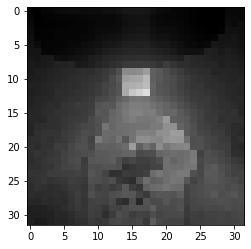

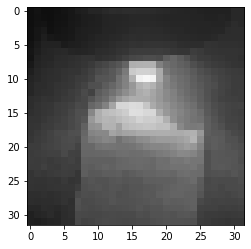

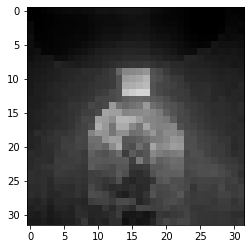

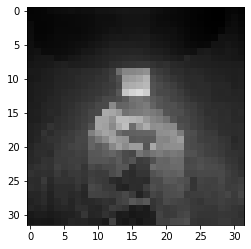

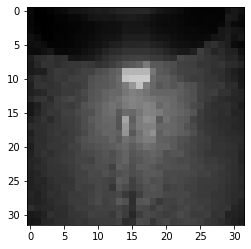

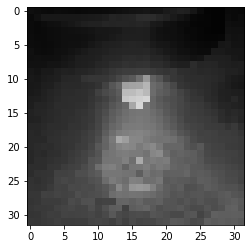

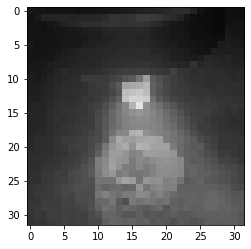

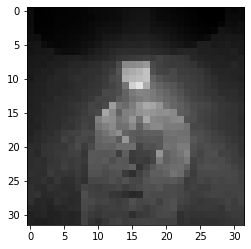

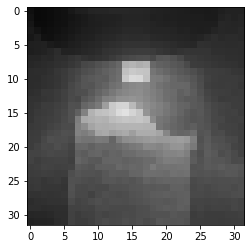

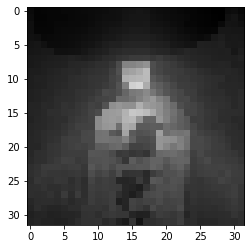

In [8]:
def DrawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.show()
    return
for i in range(10):
    DrawImg(img_data[i])

In [9]:
class SVM:
    """SVM Class, Author : Prateek Narang"""
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update 
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [10]:
img_data = img_data.reshape(img_data.shape[0],-1)

print(img_data.shape)
print(labels.shape)

(564, 3072)
(564,)


In [11]:
No_of_classes = len(np.unique(labels))

print(No_of_classes)

3


In [12]:
def classwisedata(x,y):
    data = {}
    for i in range(No_of_classes):
        data[i] = []
    
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [13]:
data = classwisedata(img_data  ,labels)

In [14]:
def getDataPairofSVM(d1,d2):
    l1,l2=d1.shape[0] , d2.shape[0]
    
    samples = l1+l2
    freatures = d1.shape[1]
    
    data_pair = np.zeros((samples , freatures))
    data_label = np.zeros((samples,))
    
    data_pair[:l1 , :] = d1
    data_pair[l1: , :] = d2
    
    data_label[:l1] = -1
    data_label[l1:] = +1
    
    return data_pair,data_label

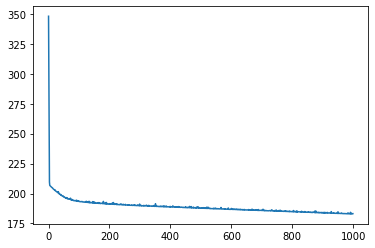

In [15]:
mySVM  = SVM()
xp, yp  = getDataPairofSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
#print(loss)
plt.plot(loss)

In [16]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(No_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1,No_of_classes):
            xpair,ypair = getDataPairofSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            plt.xlabel('Epochs'),plt.ylabel('Loss')
            plt.plot(loss)
            plt.show()
            
    
    return svm_classifiers

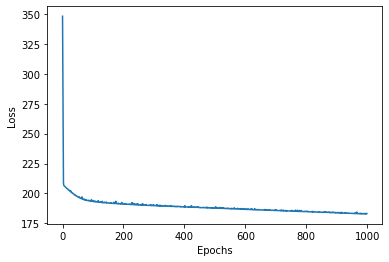

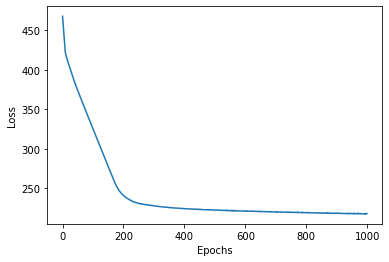

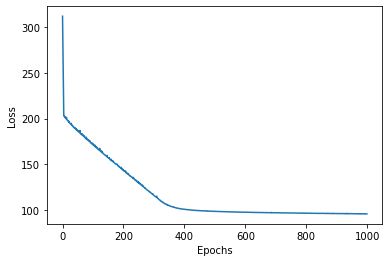

In [17]:
svm_classifiers = trainSVMs(img_data,labels)

In [18]:
#Parameters for Cats and dogs
cont_good = svm_classifiers[0][1]
cont_if = svm_classifiers[0][2]
print(cont_good[0].shape)
print(cont_good[1])

(1, 3072)
-0.05008000000000004


In [19]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [20]:
def predict(x):
    
    count = np.zeros((No_of_classes,))
    
    for i in range(No_of_classes):
        for j in range(i+1,No_of_classes):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

Target output: 0
Predicted output 0


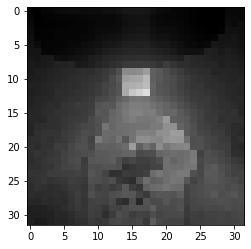

In [21]:
print( "Target output:",predict(img_data[0]))
print("Predicted output",labels[0])
a = img_data.reshape(564,32,32,3)
DrawImg(a[0])

In [22]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [23]:
accuracy(img_data,labels)

0.6453900709219859

In [24]:
import glob
dirs = glob.glob("F:\\ME_4thsem\\project\\PA\\3weld_new_dataset\\test\\*")

labels_dict = {"contamination_test":0 , "good_weld_test":1 , "lack_of_fusion_test":2 }
img_data = []
labels = []
for folder_name in dirs:
    print(folder_name)
    label  = str(folder_name).split("\\")[-1]
    print(label)

    for img_path in glob.glob(folder_name + '\\*.png'):
        img = image.load_img(img_path , target_size=(32,32))
        img_arr = image.img_to_array(img)  # totalimg*100*100*3
        img_data.append(img_arr)
        labels.append(labels_dict[label])
        
#convert this data into numpy array
img_data = np.array(img_data , dtype="float32")/255
labels = np.array(labels)
print(img_data.shape , labels.shape)
img_data = img_data.reshape(img_data.shape[0],-1)     
accuracy(img_data,labels)

F:\ME_3rdsem\project\PA\dataset\test\contamination
contamination
F:\ME_3rdsem\project\PA\dataset\test\goodweld
goodweld
F:\ME_3rdsem\project\PA\dataset\test\IF
IF
(234, 32, 32, 3) (234,)


0.8547008547008547

In [25]:
accuracy(img_data,labels)

0.8547008547008547